In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

In [86]:
# Read weather data from NYC Central Park 1960-01-29 to 2023-11-15
weather_data_init = pd.read_csv('NYC_weather_data.csv', index_col = 'DATE')
# Extract useful columns (PRCP = Precipitation (in), SNOW = Snowfall (in),
# SNWD = Snowfall (in), TMAX = Maximum Temperature (F), TMIN = Minimum Temperature (F))
weather_data = weather_data_init[['PRCP','TMAX','TMIN','SNOW','SNWD']]

# Reformat weather data (fill NAs, change index to datetime
weather_data = weather_data.fillna(value = 0)
weather_data.index = pd.to_datetime(weather_data.index)

# Find and remove any 9999 values (indicates measurement error)
print(weather_data.isin([9999]).any())

PRCP    False
TMAX    False
TMIN    False
SNOW    False
SNWD    False
dtype: bool


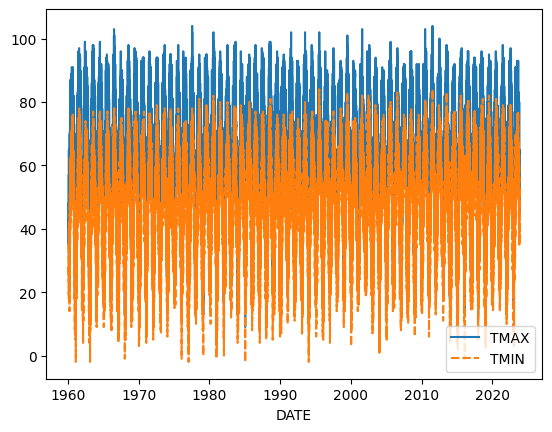

In [87]:
temp_plot = sns.lineplot(data = weather_data[['TMAX','TMIN']])

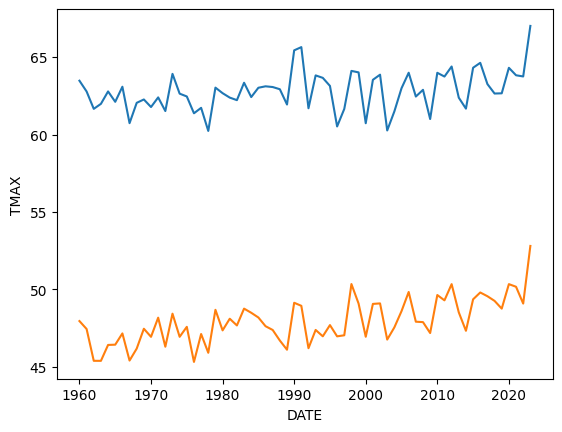

In [88]:
TMAX_by_year = sns.lineplot(data = weather_data.groupby(weather_data.index.year).mean()['TMAX'])
TMIN_by_year = sns.lineplot(data = weather_data.groupby(weather_data.index.year).mean()['TMIN'])

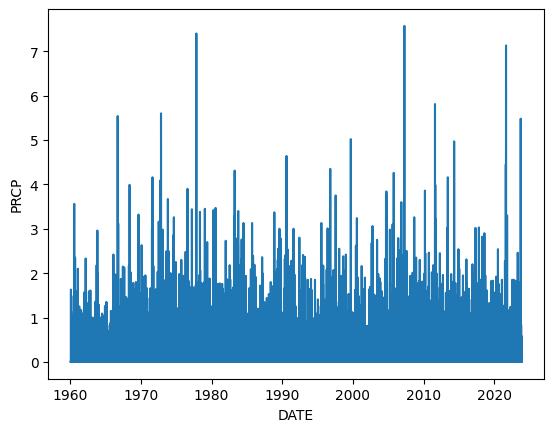

In [89]:
precip_plot = sns.lineplot(data = weather_data['PRCP'])

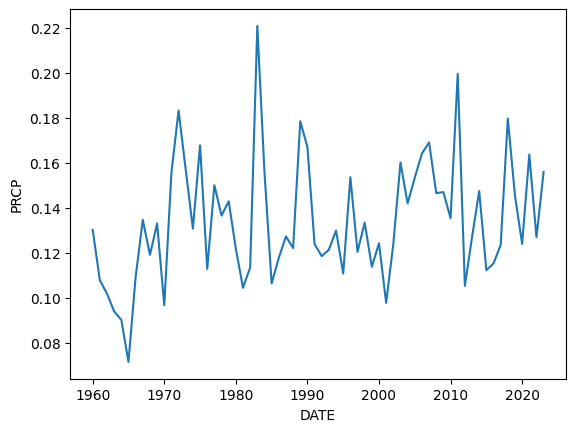

In [90]:
precip_by_year = sns.lineplot(data = weather_data.groupby(weather_data.index.year).mean()['PRCP'])

In [91]:
print(weather_data)

            PRCP  TMAX  TMIN  SNOW  SNWD
DATE                                    
1960-01-29  0.00    48    35   0.0   0.0
1960-01-30  0.00    41    30   0.0   0.0
1960-01-31  0.00    36    32   0.0   0.0
1960-02-01  0.00    36    31   0.0   0.0
1960-02-02  0.01    35    21   0.1   0.0
...          ...   ...   ...   ...   ...
2023-11-11  0.00    55    42   0.0   0.0
2023-11-12  0.00    44    36   0.0   0.0
2023-11-13  0.00    49    35   0.0   0.0
2023-11-14  0.00    53    42   0.0   0.0
2023-11-15  0.00    53    39   0.0   0.0

[23302 rows x 5 columns]


In [92]:
weather_data['Next_Day_TMAX'] = weather_data.shift(-1)['TMAX']

In [93]:
weather_data = weather_data.iloc[:-1,:].copy()

In [94]:
model = Ridge(alpha = 0.1)
predictors = ['PRCP','TMAX','TMIN']
train = weather_data.loc[:'2022-06-01']
test = weather_data.loc['2022-06-02':]
model.fit(train[predictors], train['Next_Day_TMAX'])
predicted_temperatures = model.predict(test[predictors])

In [95]:
mean_absolute_error(test['Next_Day_TMAX'], predicted_temperatures)

4.9448191352004836

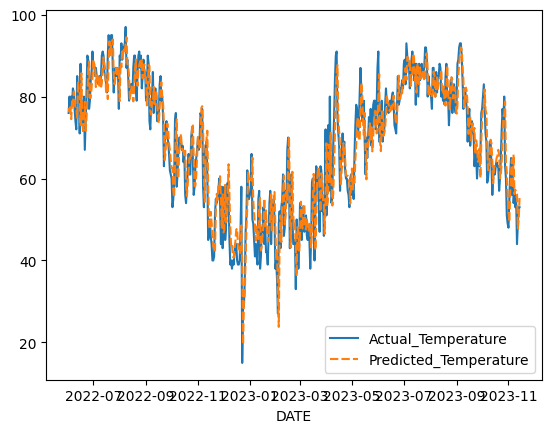

In [96]:
combined = pd.concat([test['Next_Day_TMAX'], pd.Series(predicted_temperatures, index=test.index)], axis = 1)
combined.columns = ['Actual_Temperature', 'Predicted_Temperature']
actual_vs_predicted = sns.lineplot(data = combined)

In [97]:
model.coef_

array([-1.47898422,  0.51314826,  0.46407155])

In [98]:
def predict_temperatures(predictors, weather_data, model):
    train = weather_data.loc[:'2022-06-01']
    test = weather_data.loc['2022-06-02':]
    model.fit(train[predictors], train['Next_Day_TMAX'])
    predicted_temperatures = model.predict(test[predictors])
    error = mean_absolute_error(test['Next_Day_TMAX'], predicted_temperatures)
    actual_vs_predicted = pd.concat([test['Next_Day_TMAX'], pd.Series(predicted_temperatures, index=test.index)], axis = 1)
    actual_vs_predicted.columns = ['Actual_Temperature', 'Predicted_Temperature']
    return error, actual_vs_predicted

In [99]:
weather_data['30day_max'] = weather_data['TMAX'].rolling(30).mean()
weather_data['month_day_max'] = weather_data['30day_max'] / weather_data['TMAX']
weather_data['max_min'] = weather_data['TMAX'] / (weather_data['TMIN'] + 0.001)

In [100]:
weather_data.index.month

Index([ 1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
       ...
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
      dtype='int32', name='DATE', length=23301)

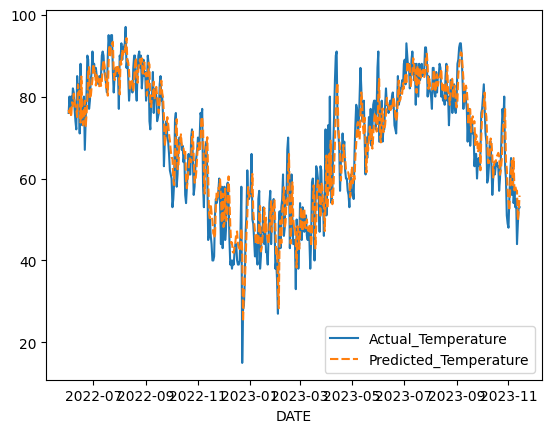

In [101]:
predictors = ['PRCP','TMAX','TMIN','30day_max','month_day_max','max_min']
weather_data = weather_data.iloc[30:,:].copy()
weather_data['TMIN'].unique()
error, avp = predict_temperatures(predictors, weather_data, model)
error
avp_plot = sns.lineplot(data = avp)

In [102]:
weather_data['monthly_avg'] = weather_data['TMAX'].groupby(weather_data.index.month, group_keys=False).apply(lambda x: x.expanding(1).mean())
weather_data['day_of_year_avg'] = weather_data['TMAX'].groupby(weather_data.index.day_of_year, group_keys=False).apply(lambda x: x.expanding(1).mean())

In [103]:
weather_data

,PRCP,TMAX,TMIN,SNOW,SNWD,Next_Day_TMAX,30day_max,month_day_max,max_min,monthly_avg,day_of_year_avg
DATE,,,,,,,,,,,
1960-02-28,0.00,41,29,0.0,0.0,36.0,42.833333,1.044715,1.413744,41.000000,41.000000
1960-02-29,0.04,36,25,0.5,1.0,32.0,42.666667,1.185185,1.439942,38.500000,36.000000
1960-03-01,0.00,32,21,0.0,0.0,36.0,42.533333,1.329167,1.523737,32.000000,32.000000
1960-03-02,0.00,36,19,0.0,0.0,27.0,42.533333,1.181481,1.894637,34.000000,36.000000
1960-03-03,0.89,27,18,12.5,0.0,29.0,42.266667,1.565432,1.499917,31.666667,27.000000
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-10,0.00,53,45,0.0,0.0,55.0,61.533333,1.161006,1.177752,54.207895,56.656250
2023-11-11,0.00,55,42,0.0,0.0,44.0,61.066667,1.110303,1.309493,54.208311,55.609375
2023-11-12,0.00,44,36,0.0,0.0,49.0,60.433333,1.373485,1.222188,54.202944,54.640625


In [105]:
predictors = ['PRCP','TMAX','TMIN','30day_max','month_day_max','max_min','monthly_avg','day_of_year_avg']
error, avp = predict_temperatures(predictors, weather_data, model)
print(error)
model.coef_

4.687419715530131


array([-1.45289332e+00,  3.93319084e-01,  2.88757600e-01, -3.21089561e-02,
       -1.00232817e-01,  3.87471386e-04,  1.34307674e-01,  2.28164331e-01])

In [106]:
weather_data.corr()['Next_Day_TMAX']

PRCP              -0.016913
TMAX               0.912079
TMIN               0.905860
SNOW              -0.174713
SNWD              -0.257386
Next_Day_TMAX      1.000000
30day_max          0.857365
month_day_max     -0.363688
max_min           -0.023235
monthly_avg        0.876436
day_of_year_avg    0.889194
Name: Next_Day_TMAX, dtype: float64

In [108]:
combined['difference'] = (combined['Actual_Temperature'] - combined['Predicted_Temperature']).abs()
combined.sort_values('difference', ascending=False).head()

,Actual_Temperature,Predicted_Temperature,difference
DATE,,,
2023-02-04,49.0,23.786460,25.213540
2022-12-23,15.0,39.307873,24.307873
2023-04-05,80.0,59.135984,20.864016
2023-04-01,51.0,68.591552,17.591552
2023-01-13,38.0,55.290303,17.290303
